In [1]:
import pandas as pd
import numpy as np 

df = pd.read_csv("../data/raw/data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17560 entries, 0 to 17559
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime_utc    17560 non-null  object 
 1   aqi_owm         17560 non-null  float64
 2   co              17560 non-null  float64
 3   no              17560 non-null  float64
 4   no2             17560 non-null  float64
 5   o3              17560 non-null  float64
 6   so2             17560 non-null  float64
 7   pm2_5           17560 non-null  float64
 8   pm10            17560 non-null  float64
 9   nh3             17560 non-null  float64
 10  lat             17560 non-null  float64
 11  lon             17560 non-null  float64
 12  calculated_aqi  17560 non-null  int64  
 13  hour            17560 non-null  int64  
 14  day_of_week     17560 non-null  int64  
 15  month           17560 non-null  int64  
 16  year            17560 non-null  int64  
 17  is_weekend      17560 non-null 

In [2]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns

Index(['aqi_owm', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3',
       'lat', 'lon', 'calculated_aqi', 'hour', 'day_of_week', 'month', 'year',
       'is_weekend', 'aqi_lag_1', 'aqi_lag_2', 'aqi_lag_3', 'aqi_lag_4',
       'aqi_6hr_avg', 'aqi_24hr_avg'],
      dtype='object')

In [3]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['datetime_utc', 'season'], dtype='object')

In [4]:
from sklearn.preprocessing import StandardScaler

# One-hot encode season
df_encoded = pd.get_dummies(df, columns=['season'], prefix='season', drop_first=False)

print("Shape after encoding:", df_encoded.shape)
print("New columns:", [col for col in df_encoded.columns if 'season' in col])

Shape after encoding: (17560, 28)
New columns: ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']


In [5]:
df_encoded.columns

Index(['datetime_utc', 'aqi_owm', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5',
       'pm10', 'nh3', 'lat', 'lon', 'calculated_aqi', 'hour', 'day_of_week',
       'month', 'year', 'is_weekend', 'aqi_lag_1', 'aqi_lag_2', 'aqi_lag_3',
       'aqi_lag_4', 'aqi_6hr_avg', 'aqi_24hr_avg', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [6]:
# Creating sine and cosine features for cyclical variables

# Hour (24-hour cycle)
df_encoded['hour_sin'] = np.sin(2 * np.pi * df_encoded['hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df_encoded['hour'] / 24)

# Day of week (7-day cycle)
df_encoded['day_of_week_sin'] = np.sin(2 * np.pi * df_encoded['day_of_week'] / 7)
df_encoded['day_of_week_cos'] = np.cos(2 * np.pi * df_encoded['day_of_week'] / 7)

# Month (12-month cycle)
df_encoded['month_sin'] = np.sin(2 * np.pi * df_encoded['month'] / 12)
df_encoded['month_cos'] = np.cos(2 * np.pi * df_encoded['month'] / 12)

print("Cyclical features created!")
print(df_encoded[['hour', 'hour_sin', 'hour_cos']].head())

Cyclical features created!
   hour  hour_sin  hour_cos
0    23 -0.258819  0.965926
1     0  0.000000  1.000000
2     1  0.258819  0.965926
3     2  0.500000  0.866025
4     3  0.707107  0.707107


In [7]:
df_encoded.columns

Index(['datetime_utc', 'aqi_owm', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5',
       'pm10', 'nh3', 'lat', 'lon', 'calculated_aqi', 'hour', 'day_of_week',
       'month', 'year', 'is_weekend', 'aqi_lag_1', 'aqi_lag_2', 'aqi_lag_3',
       'aqi_lag_4', 'aqi_6hr_avg', 'aqi_24hr_avg', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos'],
      dtype='object')

### Added below code block after doing one shap analysis, thats why I decided to only use the following features as they are the most important ones

In [ ]:
# 1. Create a 24-hour lag for PM2.5 (The "Predictor")
df_encoded['pm2_5_lag_24'] = df['pm2_5'].shift(24)


df_encoded['aqi_lag_24'] = df['calculated_aqi'].shift(24)

# 3. Create a 6-hour rolling average of PM2.5 (The "Trend")
df_encoded['pm2_5_rolling_6h'] = df['pm2_5'].shift(1).rolling(window=6).mean()

features_to_keep = [
    'pm2_5_lag_24', 'aqi_lag_24', 'pm2_5_rolling_6h', 
    'aqi_6hr_avg', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'datetime_utc', 'calculated_aqi'
]

df_processed = df_encoded[features_to_keep]

In [9]:
df_processed.columns

Index(['pm2_5_lag_24', 'aqi_lag_24', 'pm2_5_rolling_6h', 'aqi_6hr_avg',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'datetime_utc',
       'calculated_aqi'],
      dtype='object')

In [10]:
df_processed.isna().sum()

pm2_5_lag_24        24
aqi_lag_24          24
pm2_5_rolling_6h     6
aqi_6hr_avg          0
hour_sin             0
hour_cos             0
month_sin            0
month_cos            0
datetime_utc         0
calculated_aqi       0
dtype: int64

In [11]:
df_processed.dropna(inplace=True)

/tmp/ipykernel_17832/3377457182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed.dropna(inplace=True)


In [12]:
df_processed.isna().sum()

pm2_5_lag_24        0
aqi_lag_24          0
pm2_5_rolling_6h    0
aqi_6hr_avg         0
hour_sin            0
hour_cos            0
month_sin           0
month_cos           0
datetime_utc        0
calculated_aqi      0
dtype: int64

In [13]:
# Separate datetime for indexing (don't use as feature)
datetime_col = df_processed['datetime_utc']

# Define target variable
target_col = 'calculated_aqi'
y = df_processed[target_col]

# Define features (exclude datetime and target)
feature_cols = [col for col in df_processed.columns 
                if col not in ['datetime_utc', target_col]]

X = df_processed[feature_cols]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {len(feature_cols)}")

Features shape: (17536, 8)
Target shape: (17536,)
Feature columns: 8


In [14]:
from sklearn.model_selection import train_test_split

# Calculate split index (80-20 split)
split_index = int(len(df_processed) * 0.8)

# Split chronologically (NO SHUFFLING)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Also split datetime for reference
datetime_train = datetime_col.iloc[:split_index]
datetime_test = datetime_col.iloc[split_index:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training period: {datetime_train.iloc[0]} to {datetime_train.iloc[-1]}")
print(f"Test period: {datetime_test.iloc[0]} to {datetime_test.iloc[-1]}")

Training set: 14028 samples
Test set: 3508 samples
Training period: 2024-01-02 23:00:00+00:00 to 2025-08-25 10:00:00+00:00
Test period: 2025-08-25 11:00:00+00:00 to 2026-01-19 14:00:00+00:00


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Identify columns to scale (exclude binary and already normalized features)
columns_to_scale = [col for col in X_train.columns 
                    if not col.endswith('_sin')
                    and not col.endswith('_cos')]

print(f"Columns to scale: {len(columns_to_scale)}")

# Fit scaler on training data ONLY
scaler_X.fit(X_train[columns_to_scale])

# Transform both train and test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler_X.transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler_X.transform(X_test[columns_to_scale])

# Scale target variable
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

print("Scaling complete!")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Columns to scale: 4
Scaling complete!
X_train_scaled shape: (14028, 8)
X_test_scaled shape: (3508, 8)


In [16]:
# Check for any issues
print("\n" + "="*60)
print("PREPROCESSING VERIFICATION")
print("="*60)

# Check for NaN values
print(f"\nNaN in X_train_scaled: {X_train_scaled.isna().sum().sum()}")
print(f"NaN in X_test_scaled: {X_test_scaled.isna().sum().sum()}")
print(f"NaN in y_train_scaled: {np.isnan(y_train_scaled).sum()}")
print(f"NaN in y_test_scaled: {np.isnan(y_test_scaled).sum()}")

# Check data types
print(f"\nX_train_scaled dtypes:\n{X_train_scaled.dtypes.value_counts()}")

# Check for infinite values
print(f"\nInf in X_train_scaled: {np.isinf(X_train_scaled.astype(float).values).sum()}")
print(f"Inf in X_test_scaled: {np.isinf(X_test_scaled.astype(float).values).sum()}")

# Sample of scaled data
print(f"\nSample of scaled training data:")
print(X_train_scaled.head())

print("\n" + "="*60)
print("Preprocessing complete! Ready for model training.")
print("="*60)


PREPROCESSING VERIFICATION

NaN in X_train_scaled: 0
NaN in X_test_scaled: 0
NaN in y_train_scaled: 0
NaN in y_test_scaled: 0

X_train_scaled dtypes:
float64    8
Name: count, dtype: int64

Inf in X_train_scaled: 0
Inf in X_test_scaled: 0

Sample of scaled training data:
    pm2_5_lag_24  aqi_lag_24  pm2_5_rolling_6h  aqi_6hr_avg  hour_sin  \
24      1.908437    2.018335          4.523124     4.012676 -0.258819   
25      1.894430    2.007120          5.400736     4.292682  0.000000   
26      1.878364    1.973474          5.862945     4.302683  0.258819   
27      2.098042    2.220209          5.875742     4.050677  0.500000   
28      2.775717    2.960414          5.570243     3.814671  0.707107   

    hour_cos  month_sin  month_cos  
24  0.965926        0.5   0.866025  
25  1.000000        0.5   0.866025  
26  0.965926        0.5   0.866025  
27  0.866025        0.5   0.866025  
28  0.707107        0.5   0.866025  

Preprocessing complete! Ready for model training.


In [17]:
import joblib

# Save scalers - you'll need these for making predictions
joblib.dump(scaler_X, 'scaler_features.pkl')
joblib.dump(scaler_y, 'scaler_target.pkl')

print("Scalers saved!")
print("- scaler_features.pkl (for X)")
print("- scaler_target.pkl (for y)")

Scalers saved!
- scaler_features.pkl (for X)
- scaler_target.pkl (for y)


In [18]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor


# Train your model (example with Random Forest)
model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42, 
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions to check model performance
y_pred = model.predict(X_test_scaled)

print("Model trained successfully!")
print(f"Training samples: {X_train_scaled.shape[0]}") 
print(f"Test samples: {X_test_scaled.shape[0]}")

Model trained successfully!
Training samples: 14028
Test samples: 3508


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Calculate standard regression metrics
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred)

# 2. Print results
print("--- Model Performance Metrics ---")
print(f"Mean Absolute Error (MAE):    {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score):          {r2:.4f}")

--- Model Performance Metrics ---
Mean Absolute Error (MAE):    0.0881
Root Mean Squared Error (RMSE): 0.1312
R-squared (R2 Score):          0.9577


In [20]:
explainer = shap.TreeExplainer(model)

# 2. Handling the Sample
sample_size = min(2000, len(X_test_scaled))

X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)

print(f"Calculating SHAP values for {sample_size} samples...")

# 3. Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample)

print("SHAP values calculated!")
print(f"SHAP values shape: {shap_values.shape}")

Calculating SHAP values for 2000 samples...
SHAP values calculated!
SHAP values shape: (2000, 8)


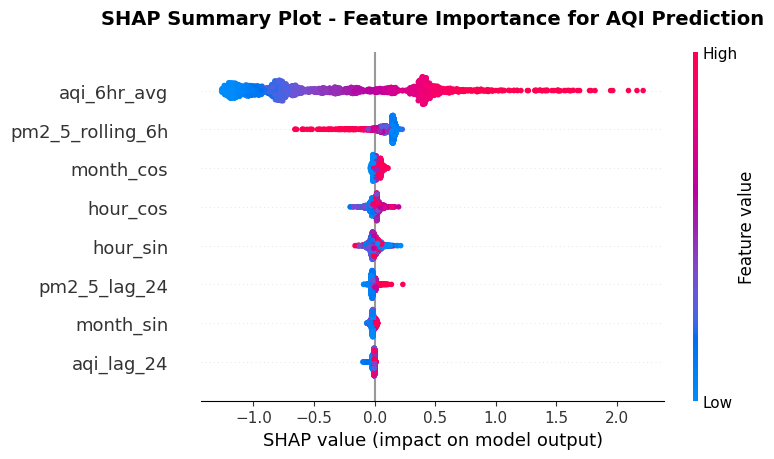


Interpretation:
- Features at the top are most important
- Red = high feature value, Blue = low feature value
- Position on x-axis shows impact on prediction
- Red dots on right = high values increase AQI prediction


In [21]:
# Summary plot - shows feature importance and impact distribution
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Feature Importance for AQI Prediction", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- Features at the top are most important")
print("- Red = high feature value, Blue = low feature value")
print("- Position on x-axis shows impact on prediction")
print("- Red dots on right = high values increase AQI prediction")

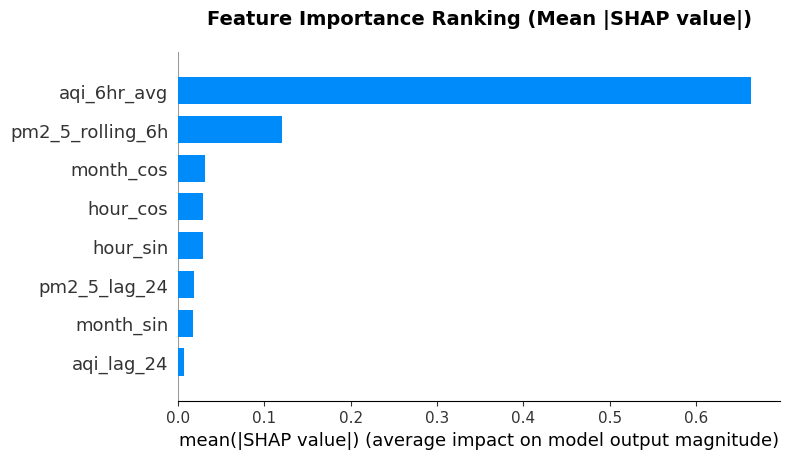

In [22]:
# Bar plot - simple feature importance ranking
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("Feature Importance Ranking (Mean |SHAP value|)", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Calculate mean absolute SHAP values for ranking
shap_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(shap_importance.head(15).to_string(index=False))
print("="*60)

# Save to CSV
shap_importance.to_csv('feature_importance_shap.csv', index=False)


TOP 15 MOST IMPORTANT FEATURES
         feature  importance
     aqi_6hr_avg    0.664261
pm2_5_rolling_6h    0.120430
       month_cos    0.031672
        hour_cos    0.029270
        hour_sin    0.028926
    pm2_5_lag_24    0.018716
       month_sin    0.016801
      aqi_lag_24    0.006790


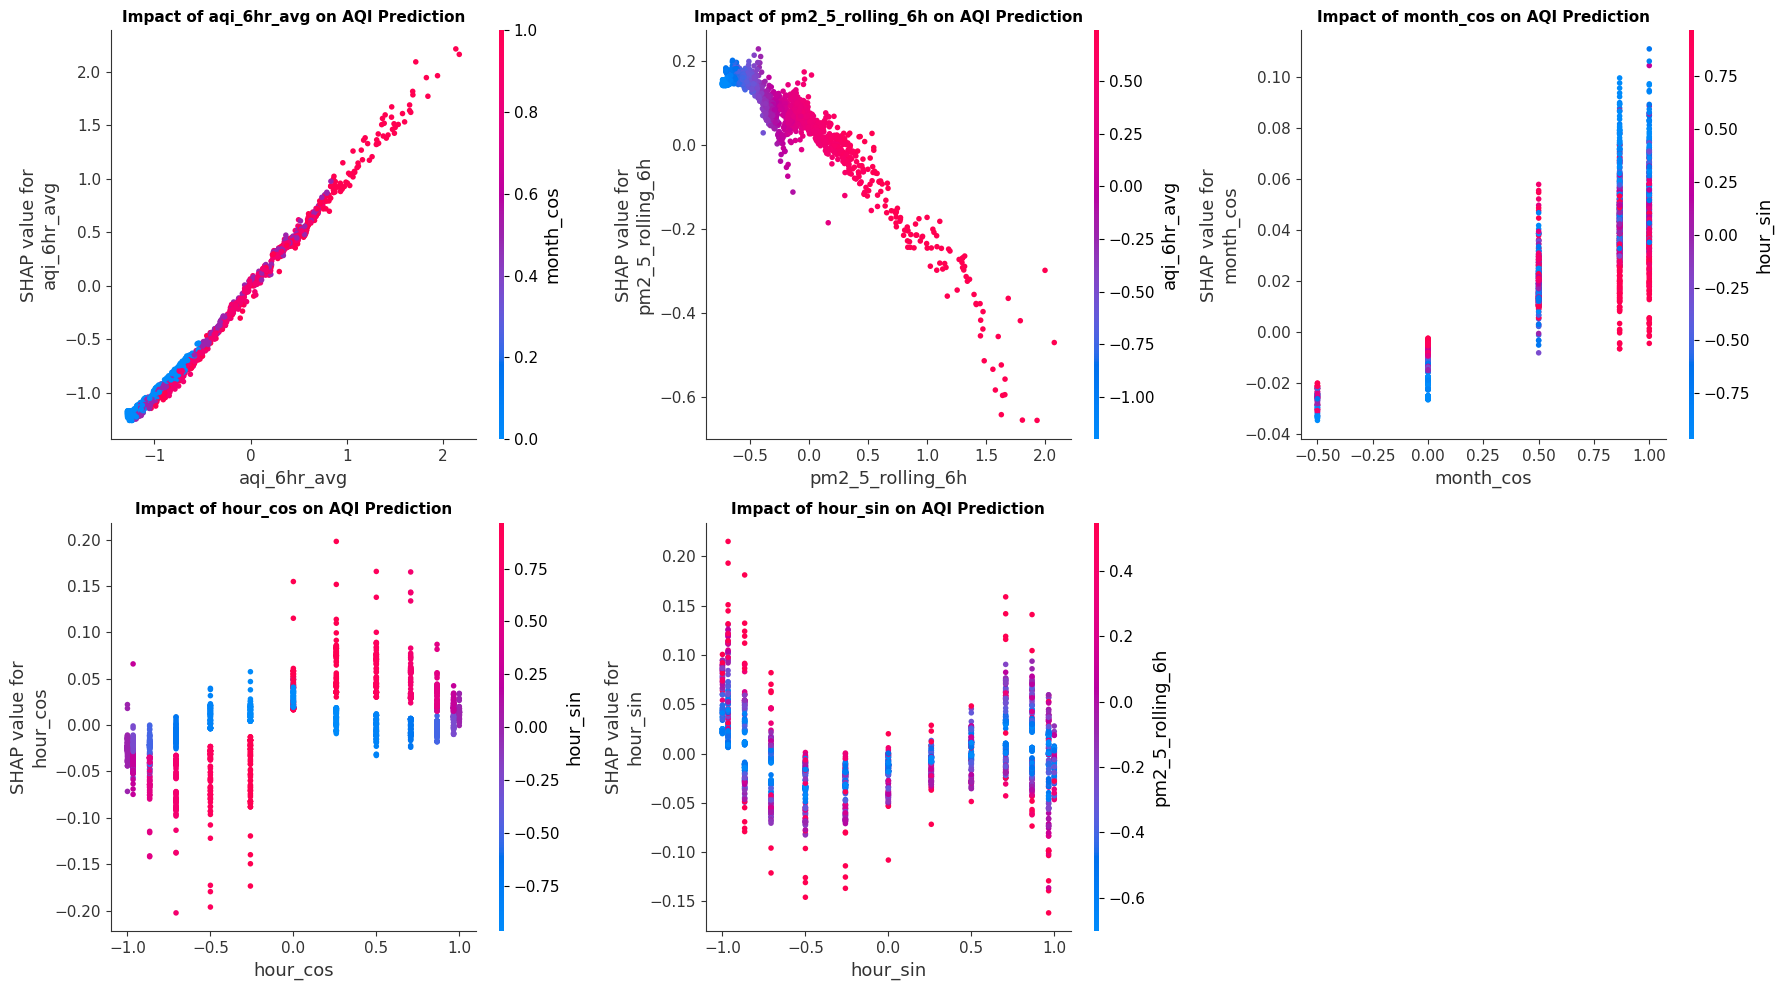


Dependence plots created for top 5 features


In [24]:
# Create dependence plots for top 5 features
top_features = shap_importance['feature'].head(5).tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_test_sample, 
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Impact of {feature} on AQI Prediction', 
                       fontsize=11, fontweight='bold')

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDependence plots created for top 5 features")

#### SHAP Analysis Outcome

The final feature set was selected through an iterative SHAP (SHapley Additive exPlanations) analysis to transition the model from a regression-based calculator to a true temporal forecaster. Initial SHAP summary plots identified significant "formula leakage," where the model achieved an $R^2$ of 0.9989 by primarily using current-hour pollutant PM_25 concentrations to calculate the simultaneous AQI value. To ensure the model could generalize for 72-hour predictions where future pollutant levels are unknown, all current-hour features were removed.

The refined feature selection focuses on three primary categories of predictive signals:

**Atmospheric Momentum**: aqi_6hr_avg and pm2_5_rolling_6h were introduced as the primary drivers, providing a stable baseline of the immediate atmospheric trend rather than a single-point snapshot.

**Diurnal Periodicity**: 24-hour lags (pm2_5_lag_24, aqi_lag_24) were selected to capture the strong 24-hour cycle observed in Karachi's urban pollution patterns.

**Temporal Anchors**: Cyclical time features (hour_cos, month_cos) shifted from negligible importance to major contributors, allowing the model to apply seasonal and daily rush-hour weights to the forecast.

**Dimensionality Reduction**: Low-impact features identified by SHAP, including nh3, so2, no, and is_weekend, were pruned to reduce noise and prevent error accumulation during the recursive 72-hour loop.

In [25]:
df_processed.head()

,pm2_5_lag_24,aqi_lag_24,pm2_5_rolling_6h,aqi_6hr_avg,hour_sin,hour_cos,month_sin,month_cos,datetime_utc,calculated_aqi
24,252.74,303.0,465.831667,457.000000,-0.258819,0.965926,0.5,0.866025,2024-01-02 23:00:00+00:00,500
25,251.38,302.0,543.208333,480.333333,0.000000,1.000000,0.5,0.866025,2024-01-03 00:00:00+00:00,500
26,249.82,299.0,583.960000,481.166667,0.258819,0.965926,0.5,0.866025,2024-01-03 01:00:00+00:00,415
27,271.15,321.0,585.088333,460.166667,0.500000,0.866025,0.5,0.866025,2024-01-03 02:00:00+00:00,346
28,336.95,387.0,558.153333,440.500000,0.707107,0.707107,0.5,0.866025,2024-01-03 03:00:00+00:00,382
